In [2]:
import random
import string

import numpy as np
import scipy as sp

import pandas as pd

from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import confusion_matrix

from sklearn.decomposition import FactorAnalysis as fa

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# utility functions
def generate_string(lenght):
    return ''.join(random.choices(string.ascii_uppercase + string.ascii_lowercase, k=lenght))

def generate_mapping(df, column):
    return {label : code for code, label in enumerate(df[column].unique())}

# dataframe functions
def categorical_noise(column, ammount):
    ammount = int(len(column) * ammount)
    sample = np.random.choice(column.index, ammount)
    string = generate_string(5)
    column.loc[sample] = column.loc[sample].apply(lambda x: string)
    return column

def scalar_noise(column, ammount):
    ammount = int(len(column) * ammount)
    sample = np.random.choice(column.index, ammount)
    std = column.std()
    column.loc[sample] = column.loc[sample].apply(lambda x: x + std*10)
    return column
        
def add_noise (df, n_columns):
    columns = list(df)
    for column in np.random.choice(columns, n_columns):
        
        if df[column].dtype == 'object':
            df[column] = categorical_noise(df[column], 0.5)
        elif df[column].dtype in ['int64', 'int32', 'float64', 'float32']:
            df[column] = scalar_noise(df[column], 0.5)
    
    return df

def add_spurious_columns (df, n_columns):
    for column in range(n_columns):
        
        df['spurious_'+str(column)] = np.random.normal(0, 5, len(df))
    
    return df

def generate_synthetic(n_categorical, n_scalar, n_rows):
    df = pd.DataFrame()
    for column in range(n_categorical):
        
        categories = [generate_string(5) for category in range(3)]
        df['categorical_'+str(column)] = np.random.choice(categories, n_rows)
    
    for column in range(n_scalar):
        
        df['scalar_'+str(column)] = np.random.normal(0, 1, n_rows)

    return pd.DataFrame(df)

# data preparation functions
def generate_X_y(df, X_columns, y_column):
    X = np.array(df[X_columns]) 
    y = np.array(df[y_column])
    return X, y

In [4]:
df = pd.read_csv('C:\\Users\\penthotal\\Desktop\\IGGI\\collaborations\\personal_projects\\data_viz_python\\data\\dataframe.csv')
df_ml = pd.read_csv('C:\\Users\\penthotal\\Desktop\\IGGI\\collaborations\\personal_projects\\data_viz_python\\data\\dataframe_ml.csv')

WHAT, WHY, WHERE, HOW DATA VISUALIZATION

BRIEF INTRODUCTION PANDAS DATAFRAMES, MATPLOTLIB AND SEABORN

EXPLORATORY DATA VISUALIZATION

* distplot and count plot
* ridge plot
* Joint kernel density estimate

EXERCISE 1

* revelation of the data source
* discover the characteristics of the dataframe you are working on
* discover anomalies in the data

DATA VISUALIZATION FOR HYPOTHESIS TESTING
* line plot
* scatter plot and confusion matrix
* boxplot

EXERCISE 2
* find and test your own hp!

DATA VISUALIZATION FOR MODEL EVALUATION
* model performance (line plot, box plot)
* model accuracy (line plot, boxplot, confusion matrix)
* model inspection (scatter plot)

### Compare the performance of various models

In [11]:
X, y = generate_X_y(df_ml, ['class', 'experience', 'dead', 'ladder', 'online'], 'twitch')
classifiers = {'Random Forest' : RandomForestClassifier()
               , 'Decision Tree' : DecisionTreeClassifier()
               , 'Ada Boost' :  AdaBoostClassifier()
               , 'Gradient Tree Boosting' : GradientBoostingClassifier()
              }

In [12]:
splitter = StratifiedShuffleSplit(n_splits=5)
scores = []
names = []
for name, classifier in classifiers.items():
    
    for train_index, test_index in splitter.split(X, y):
        
        classifier.fit(X[train_index], y[train_index])
        scores.append(classifier.score(X[test_index], y[test_index]))
        names.append(name)

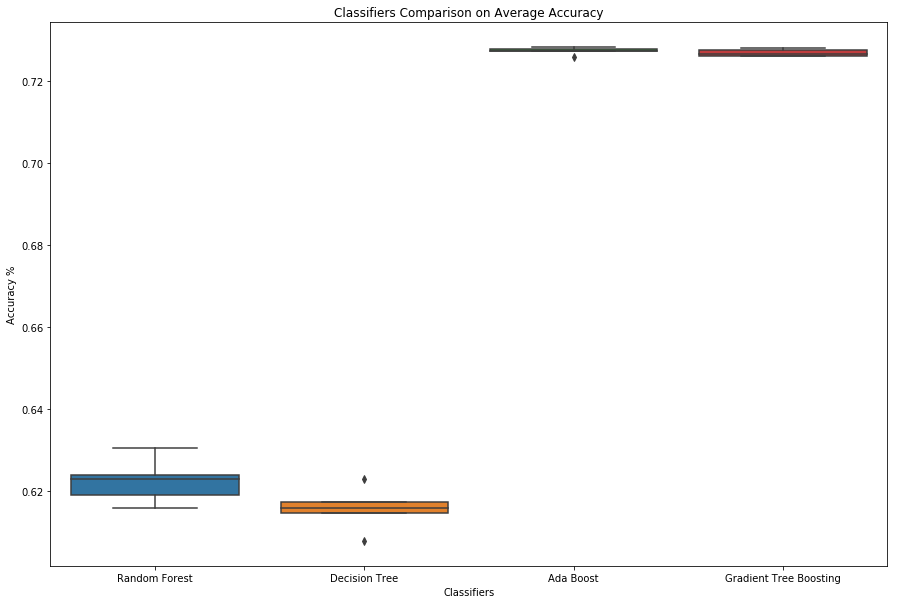

In [13]:
plt.figure(figsize = (15, 10))
sns.boxplot(x = names, y = scores, orient = 'v')
plt.title('Classifiers Comparison on Average Accuracy')
plt.xlabel('Classifiers')
plt.ylabel('Accuracy %')
plt.show()

### Evaluate impact of hyperparameter change

In [35]:
df_ml = add_spurious_columns(df_ml, 6)
X, y = generate_X_y(df_ml, ['level', 'experience', 'challenges', 'spurious_0', 'spurious_1', 'spurious_2', 'spurious_3', 'spurious_4', 'spurious_5'], 'dead')

In [36]:
splitter = StratifiedShuffleSplit(n_splits=2)
regularization = np.linspace(10, 0.00001, 10)
scores = []
c_values = []
for C in regularization:
    
    classifier = LogisticRegression(penalty = 'l1', C = C, max_iter = 50)
    
    for train_index, test_index in splitter.split(X, y):

        classifier.fit(X[train_index], y[train_index])
        scores.append(classifier.score(X[test_index], y[test_index]))
        c_values.append(C)

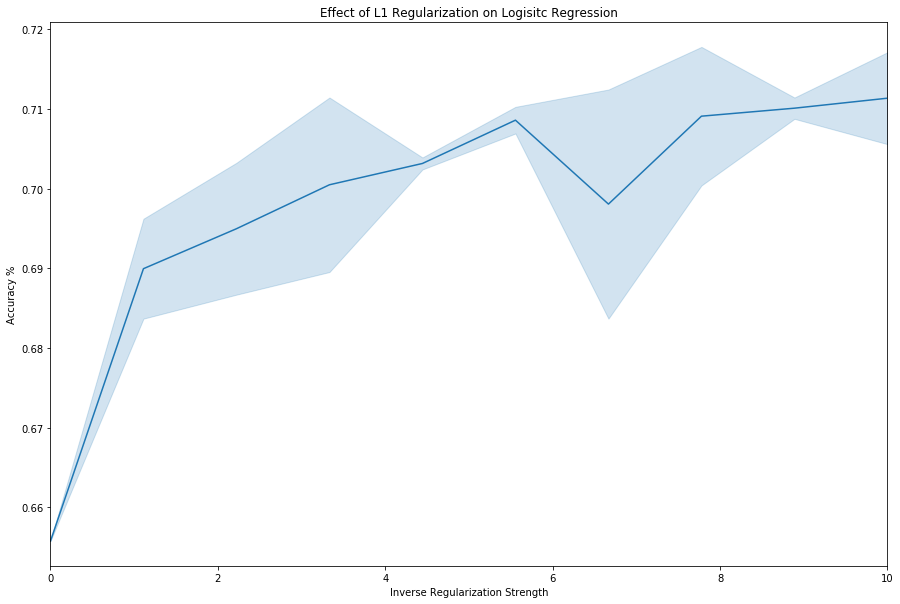

In [37]:
plt.figure(figsize = (15, 10))
sns.lineplot(x= c_values, y =  scores)
plt.xlim(xmin=min(regularization), xmax=max(regularization))
plt.title('Effect of L1 Regularization on Logisitc Regression')
plt.xlabel('Inverse Regularization Strength')
plt.ylabel('Accuracy %')
plt.show()

### Evaluate the performance of a model in more detail

In [38]:
X, y = generate_X_y(df_ml, ['class', 'twitch', 'ladder', 'online'], 'dead')
param_grid = {'n_estimators' : [10, 50, 100]
              , 'criterion' : ['gini', 'entropy']
              , 'max_depth' : [10, 50, 100]
             }
for validation_index, test_index in StratifiedShuffleSplit(n_splits = 1).split(X, y):
    
    X_validation, y_validation = X[validation_index], y[validation_index]
    X_test, y_test = X[test_index], y[test_index]

In [41]:
splitter = StratifiedShuffleSplit(n_splits= 2)
searcher = GridSearchCV(estimator=classifiers['Random Forest']
                        , param_grid=param_grid
                        , scoring='roc_auc'
                        , cv=splitter
                        )
searcher.fit(X_validation, y_validation)
classifier = searcher.best_estimator_
y_predicted=classifier.predict(X_test)
c_m = confusion_matrix(y_true=y_test, y_pred=y_predicted)

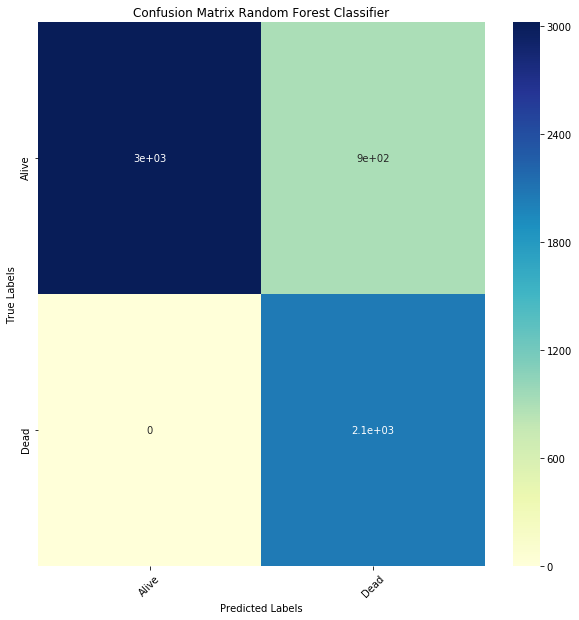

In [42]:
plt.figure(figsize = (10, 10))
sns.heatmap(c_m, annot = True, cmap='YlGnBu')
plt.xticks([0.5, 1.5], ['Alive', 'Dead'], rotation=45)
plt.yticks([0.5, 1.5], ['Alive', 'Dead'])
plt.title('Confusion Matrix Random Forest Classifier')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

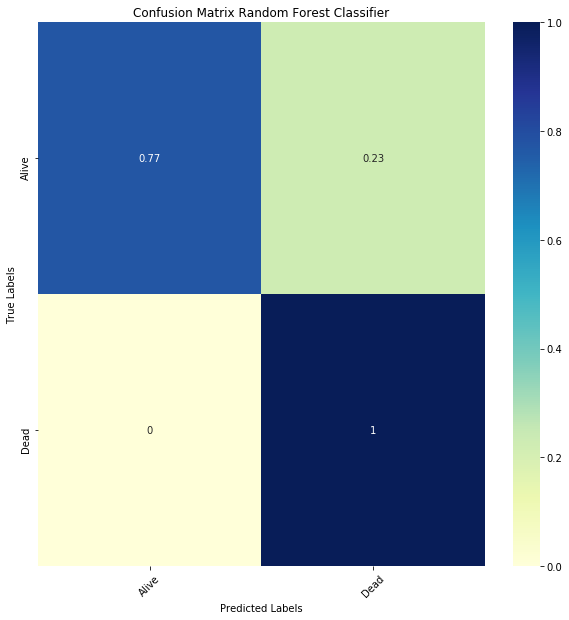

In [43]:
plt.figure(figsize = (10, 10))
sns.heatmap(c_m / c_m.sum(axis=1)[:, np.newaxis], annot = True, cmap='YlGnBu')
plt.xticks([0.5, 1.5], ['Alive', 'Dead'], rotation=45)
plt.yticks([0.5, 1.5], ['Alive', 'Dead'])
plt.title('Confusion Matrix Random Forest Classifier')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Inspect the prediction

In [44]:
vvv = fa(n_components = 2).fit_transform(X)

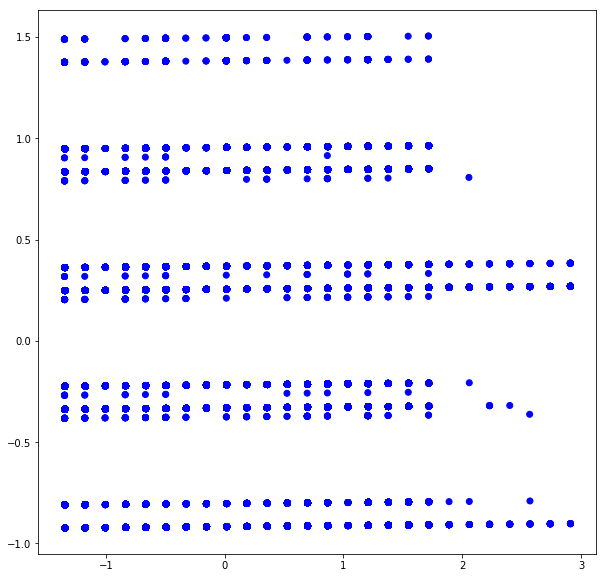

In [48]:
plt.figure(figsize=(10,10))
plt.scatter(vvv[:,0], vvv[:,1], c = y_predicted)
plt.show()

In [46]:
y_predicted = ['r' if 0 else 'b' for prediction in y_predicted]

In [50]:
for x in y_predicted:
    
    if x != 'b':
        print(x)